In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

2024-06-16 12:26:54.204845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 12:26:55.146426: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/miniconda3/envs/tf_env/lib/python3.9/site-packages/nvidia/cudnn/lib:/opt/miniconda3/envs/tf_env/lib/
2024-06-16 12:26:55.146582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/miniconda3/envs/t

In [2]:
batch_size = 32
latent_dim = 100
input_shape = [32, 32, 3]

In [3]:
def load_dataset():
    (X_train, _), (_, _) = keras.datasets.cifar10.load_data()
    n_images = X_train.shape[0]
    X_train = X_train.astype(np.float32) / 255
    
    X_train_dcgan = X_train.reshape(-1, 32, 32, 3) * 2. -1

    dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
    dataset = dataset.shuffle(n_images)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
    
    return dataset


In [4]:
def plot_images(images, n_cols = 6):
    images = (images + 1) / 2.0
    n_images = images.shape[0]
    n_rows = n_images // n_cols + 1
    figure = plt.figure(figsize=(n_rows, n_cols))
    for i in range(n_images):
        figure.add_subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

In [5]:
def discriminator(input_shape):
    
    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape=input_shape))
    model.add(keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
    return model

def generator(latent_dim):
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.Input(shape=[latent_dim]))
    model.add(keras.layers.Dense(4*4*128))
    model.add(keras.layers.Reshape([4,4,128]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(3, kernel_size=3, padding="SAME", activation="tanh"))
    
    return model

In [6]:
def gan(generator, discriminator):
    discriminator.trainable = False
    gan = keras.models.Sequential([generator, discriminator])
    gan.compile(loss="binary_crossentropy", optimizer="rmsprop")
    return gan

In [7]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):  
        print(f"\nEpoch {epoch + 1}/{n_epochs}")
        progbar = keras.utils.Progbar(50000 / batch_size)
        for i, X_batch in enumerate(dataset):
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            d_loss, _ = discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
            progbar.add(1, values=[("d_loss", d_loss), ("g_loss", g_loss)])
        if (epoch + 1) % 10 == 0:
            plot_images(generated_images, 6)

In [8]:
g_model = generator(latent_dim)
d_model = discriminator(input_shape)

gan_model = gan(g_model, d_model)

dataset = load_dataset()

2024-06-16 12:26:56.547073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 12:26:56.610714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 12:26:56.610776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 12:26:56.611749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

2024-06-16 12:26:59.814817: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.



Epoch 1/50


2024-06-16 12:27:00.171209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2024-06-16 12:27:00.951306: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-16 12:27:01.113791: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe8e6ceae10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-16 12:27:01.113850: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-06-16 12:27:01.121139: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-16 12:27:01.226950: I tensorflow/compiler/jit/xla_compilation_cache

1561/1562 [============================>.] - ETA: 0s - d_loss: 0.4727 - g_loss: 1.3650
Epoch 2/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5401 - g_loss: 1.4197
Epoch 3/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5451 - g_loss: 1.3898
Epoch 4/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5263 - g_loss: 1.5205
Epoch 5/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5284 - g_loss: 1.5264
Epoch 6/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5315 - g_loss: 1.5079
Epoch 7/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5308 - g_loss: 1.5482
Epoch 8/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5236 - g_loss: 1.5887
Epoch 9/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5293 - g_loss: 1.5837
Epoch 10/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5226 - g_loss: 1.6330

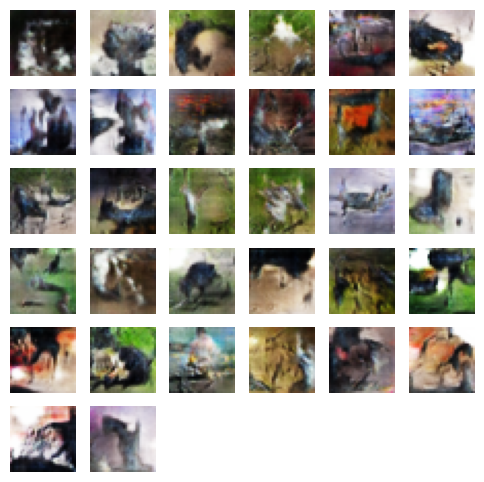


Epoch 11/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5274 - g_loss: 1.6407
Epoch 12/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5309 - g_loss: 1.6323
Epoch 13/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5273 - g_loss: 1.6400
Epoch 14/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5223 - g_loss: 1.6911
Epoch 15/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5285 - g_loss: 1.6771
Epoch 16/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5292 - g_loss: 1.6871
Epoch 17/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5251 - g_loss: 1.7061
Epoch 18/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5235 - g_loss: 1.7072
Epoch 19/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5228 - g_loss: 1.7445
Epoch 20/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5211 - g_loss: 1.7473

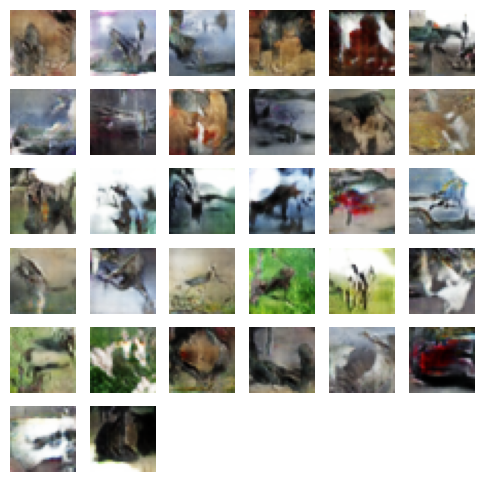


Epoch 21/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5212 - g_loss: 1.7878
Epoch 22/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5201 - g_loss: 1.7743
Epoch 23/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5206 - g_loss: 1.7850
Epoch 24/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5202 - g_loss: 1.7947
Epoch 25/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5108 - g_loss: 1.8340
Epoch 26/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5137 - g_loss: 1.8361
Epoch 27/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5147 - g_loss: 1.8342
Epoch 28/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5134 - g_loss: 1.8660
Epoch 29/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5135 - g_loss: 1.8485
Epoch 30/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5137 - g_loss: 1.8794

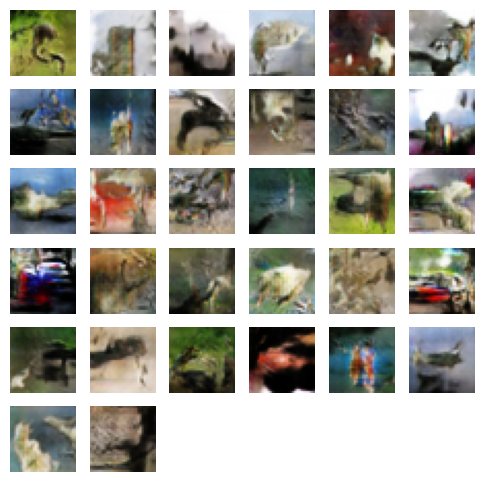


Epoch 31/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5144 - g_loss: 1.8730
Epoch 32/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5108 - g_loss: 1.8962
Epoch 33/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5096 - g_loss: 1.9119
Epoch 34/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5110 - g_loss: 1.8883
Epoch 35/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5128 - g_loss: 1.9111
Epoch 36/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5093 - g_loss: 1.9146
Epoch 37/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5117 - g_loss: 1.9225
Epoch 38/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5099 - g_loss: 1.9182
Epoch 39/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5113 - g_loss: 1.9404
Epoch 40/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5090 - g_loss: 1.9293

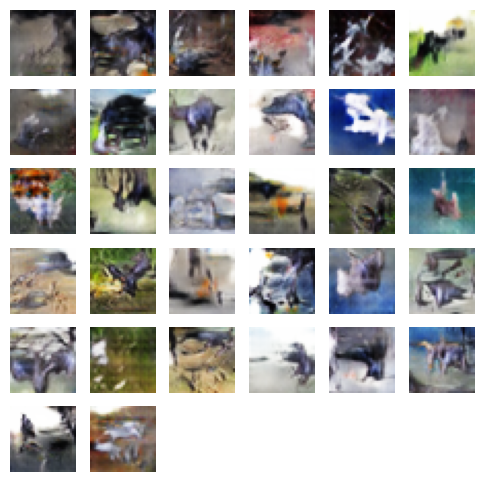


Epoch 41/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5070 - g_loss: 1.9482
Epoch 42/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5068 - g_loss: 1.9470
Epoch 43/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5052 - g_loss: 1.9646
Epoch 44/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5025 - g_loss: 1.9858
Epoch 45/50
1561/1562 [============================>.] - ETA: 0s - d_loss: 0.5020 - g_loss: 1.9773
Epoch 46/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5027 - g_loss: 2.0023
Epoch 47/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.4976 - g_loss: 2.0082
Epoch 48/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5010 - g_loss: 2.0388
Epoch 49/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.4986 - g_loss: 2.0223
Epoch 50/50
1562/1562 [============================>.] - ETA: 0s - d_loss: 0.5005 - g_loss: 2.0125

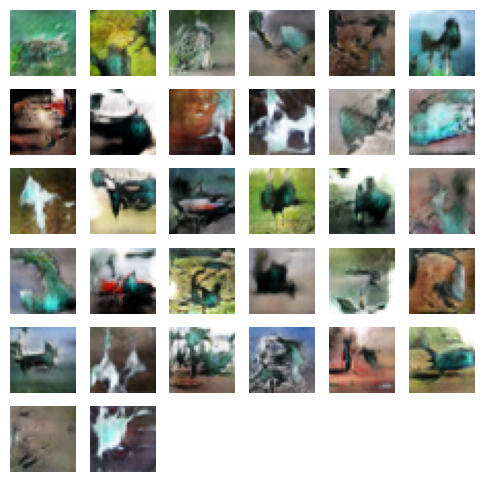

In [9]:
train_gan(gan_model, dataset, batch_size, latent_dim)

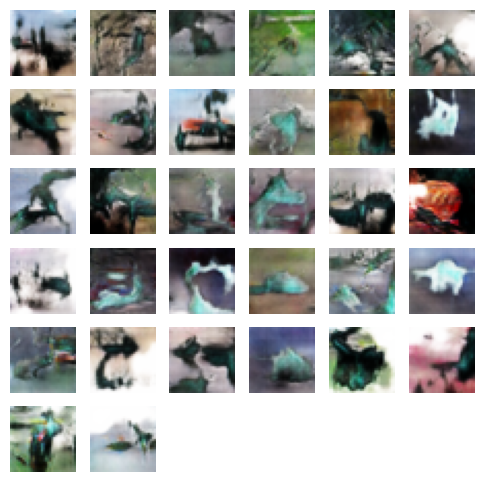

In [10]:
noise = tf.random.normal(shape=[batch_size, latent_dim])
generated_images = g_model(noise)
plot_images(generated_images)